In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import numpy as np
from PIL import Image
import torch.utils.data.dataset as datautil


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [2]:
# need to do this twice for it to work for some reason
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Load preprocessed dataset mean and standard deviation 

Text(0.5,1,'Std image')

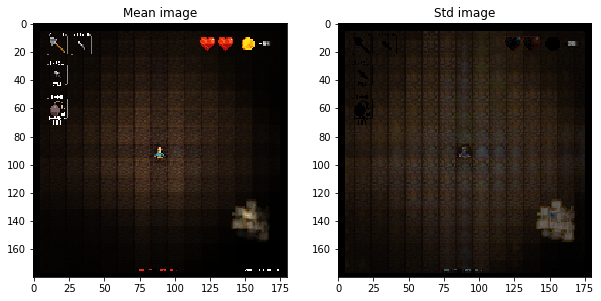

In [3]:
dset_mean = np.load("stats/dsetMean.npy")
dset_std = np.load("stats/dsetStd.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

Pytorch expects the data shape to be CxHxW (instead of the current HxWxC) so we reshape the mean and std image here, then use them to calculate the means for the three color channels. For images in the training data, this transposition is handled when the dataset object applies the ToTensor() transformation.

In [4]:
dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))
print(dset_mean.shape, dset_std.shape)

(3, 180, 180) (3, 180, 180)


Finally, calculate the mean and std over the three image channels.

In [5]:
channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255 #TODO: just conver to tensor so that you don't have to do this division manually

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

Per-channel means:
[0.09857196 0.06631106 0.0443993 ]
Per-channel stds:
[0.12317732 0.09331372 0.07770979]


# Initialize dataset and data loader objects
Use the channel mean and std to define a normalization transform which our dataset object will apply to each of its images upon loading them.

In [6]:
image_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize(channel_means, channel_stds)
])

dataset = datasets.DatasetFolder(root='classes/normalized', extensions=['npy'], loader=np.load, transform=image_transform)
# train_dataset = datasets.ImageFolder(root='classes/downscaled', transform=image_transform)
num_train = len(dataset)
print("Training set has {} examples.".format(num_train))

num_val = num_train//10

permutation = np.random.RandomState(seed=0).permutation(num_train)

val_dataset = datautil.Subset(dataset, permutation[:num_val])
train_dataset = datautil.Subset(dataset, permutation[num_val:])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_train-num_val)))

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_val)))

Training set has 1043 examples.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 180, 180])
(3, 180, 180)


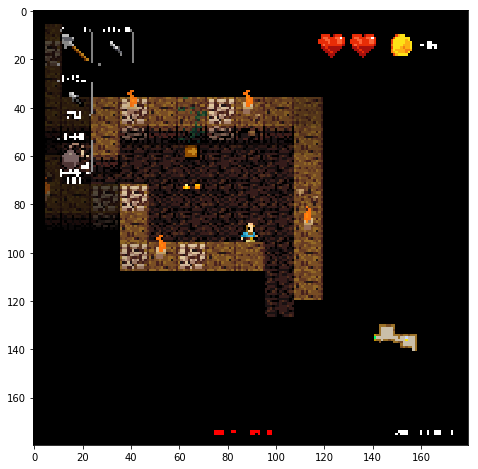

In [7]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images[0].shape)
print(dset_mean.shape)

plt.imshow((images[0].numpy() * dset_std/255 + dset_mean/255).transpose(1,2,0))

# plt.imshow((images[0].numpy() * channel_stds.reshape((3,1,1)) + channel_means.reshape((3,1,1))).transpose(1,2,0))

# Define training and validation functions

In [8]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50000

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


In [13]:
def check_model_accuracy(loader, model, name): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('%s set: Got %d / %d correct (%.2f)' % (name, num_correct, num_samples, 100 * acc))
    return acc

In [14]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_losses, val_losses = [], []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train_losses.append(check_model_accuracy(train_loader, model, 'Train'))
                val_losses.append(check_model_accuracy(val_loader, model, 'Val'))
                print()
    return (train_losses, val_losses)

# Define model

In [15]:
hidden_layer_size = 4000
learning_rate = 1e-3

num_classes = 4

model = nn.Sequential(
    nn.Conv2d(3, 32, 6, stride=3, padding=9), # 32x64x64
    nn.ReLU(),
    nn.Conv2d(32, 16, 3, stride=1, padding=1), # 16x64x64
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, stride=2, padding=0), # 16x32x32
    nn.ReLU(),
#     nn.Conv2d(32, 16, 3, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(16, 16, 3, padding=1),
#     nn.ReLU(),
    Flatten(),
    nn.Linear(16*32*32, num_classes),
)

# you can use Nesterov momentum in optim.SGD
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                      momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters())


# Train on the dataset!

In [17]:
train_losses, val_losses = train_model(model, optimizer, epochs=20)

Iteration 0, loss = 1.2416
Train set: Got 453 / 939 correct (48.24)
Val set: Got 49 / 104 correct (47.12)

Iteration 0, loss = 0.9856
Train set: Got 524 / 939 correct (55.80)
Val set: Got 48 / 104 correct (46.15)

Iteration 0, loss = 0.8951
Train set: Got 592 / 939 correct (63.05)
Val set: Got 44 / 104 correct (42.31)

Iteration 0, loss = 0.8542
Train set: Got 640 / 939 correct (68.16)
Val set: Got 54 / 104 correct (51.92)

Iteration 0, loss = 0.6881
Train set: Got 696 / 939 correct (74.12)
Val set: Got 54 / 104 correct (51.92)

Iteration 0, loss = 0.5000
Train set: Got 732 / 939 correct (77.96)
Val set: Got 49 / 104 correct (47.12)

Iteration 0, loss = 0.4810
Train set: Got 766 / 939 correct (81.58)
Val set: Got 47 / 104 correct (45.19)

Iteration 0, loss = 0.3752
Train set: Got 817 / 939 correct (87.01)
Val set: Got 50 / 104 correct (48.08)

Iteration 0, loss = 0.2796
Train set: Got 823 / 939 correct (87.65)
Val set: Got 47 / 104 correct (45.19)

Iteration 0, loss = 0.3458
Train set:

<function matplotlib.pyplot.show(*args, **kw)>

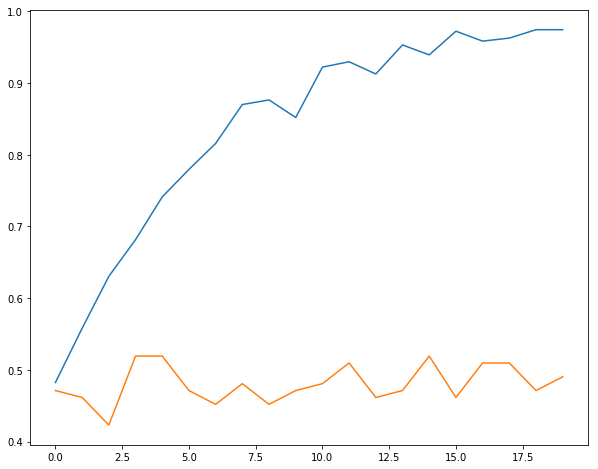

In [18]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show